# Imports


In [313]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from itertools import product


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Utility functions 

In [109]:
def plot_feature_distributions(data:pd.DataFrame , feature_names:list) -> None :
    """
    Plots Feature distributions
    @param data - pandas data frame of data
    @param feature_names - names of features to plot
    """
    num_features = len(feature_names)
    num_rows = num_features // 2 + num_features % 2  

    plt.figure(figsize=(12, 4 * num_rows))  

    for i, feature in enumerate(feature_names):
        plt.subplot(num_rows, 2, i + 1)   
        sns.histplot(data[feature], kde=True)
        plt.title(feature)

    plt.tight_layout()
    plt.show()
    
def plot_feature_boxplots(data:pd.DataFrame, feature_names:list, y_label:str)-> None :
    """
    Plots Feature distributions
    @param data - pandas data frame of data
    @param feature_names - names of features to plot - should be continous features 
    @param y_label - used for comparison of x values 
    """
    num_features = len(feature_names)
    num_rows = num_features // 2 + num_features % 2  

    plt.figure(figsize=(12, 4 * num_rows))  

    for i, feature in enumerate(feature_names):
        plt.subplot(num_rows, 2, i + 1)   
        sns.boxplot(x=y_label, y=feature, data=data)
        plt.title(feature)

    plt.tight_layout()
    plt.show()
    

def print_results(y_actual:list, y_pred:list, y_labels:list)-> None :
    """
    Prints confusion matrix of given predicted values 
    @param y_actual-
    @param y_pred-
    @param x_labels-
    @param y_labels-
    """
    accuracy = accuracy_score(y_actual, y_pred)
    
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'Accuracy: {accuracy*100:.2f}%')
    


# Data import and analysis 

In [30]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [45]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [79]:
# understand label skew.  
train['Survived_c'] = pd.Categorical.from_codes(train['Survived'], ['no','yes'])
print(train['Survived'].value_counts())
print(train['Survived_c'].value_counts())


0    549
1    342
Name: Survived, dtype: int64
no     549
yes    342
Name: Survived_c, dtype: int64


In [32]:
# determine missing values 
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [47]:
# good to also look at missing values in test set
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

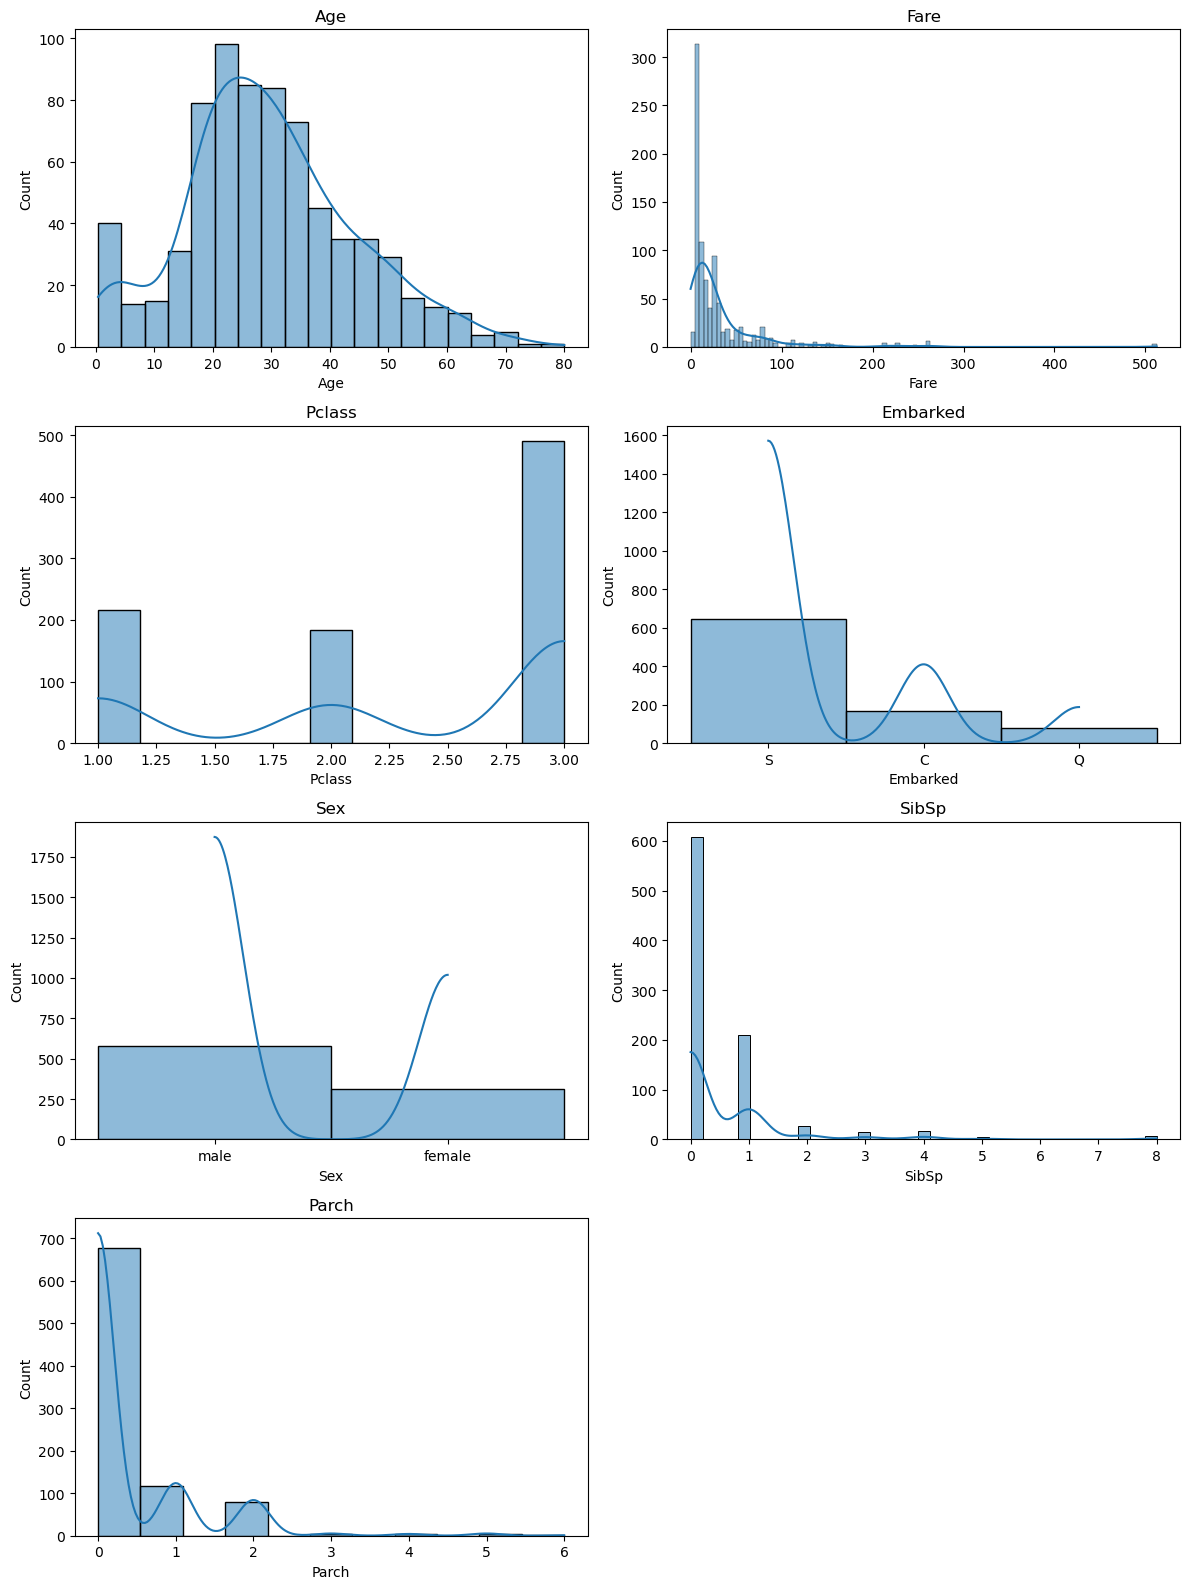

In [34]:
feature_names = ['Age','Fare','Pclass','Embarked', 'Sex', 'SibSp', 'Parch']
plot_feature_distributions(train, feature_names)

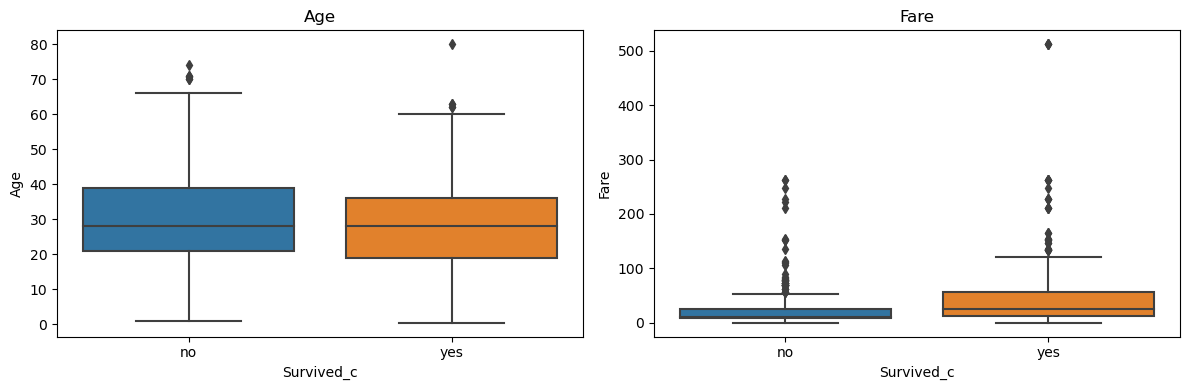

In [80]:
feature_names = ['Age','Fare']
plot_feature_boxplots(train, feature_names, 'Survived_c')

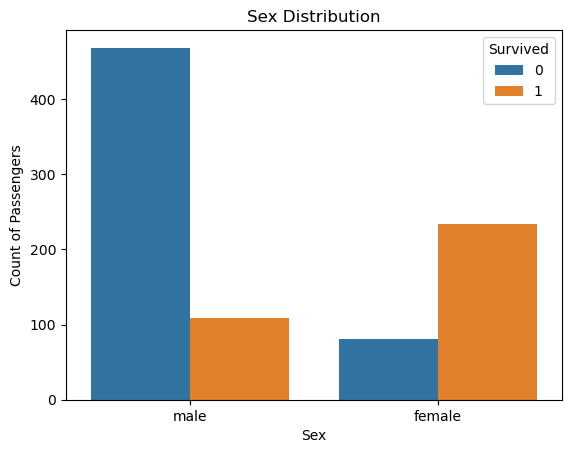

In [310]:
sns.countplot(data=train, x='Sex', hue='Survived')
plt.xlabel('Sex')
plt.ylabel('Count of Passengers')
plt.title('Sex Distribution')
plt.show()

In [130]:
print(train['Embarked'].value_counts())
print(train['Sex'].value_counts())
print(train['SibSp'].value_counts())
print(train['Parch'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


# Data class setup

In [291]:
class Titanic_data():
    
    def __init__(self, train, test_x, y_col):
        """
        @param train - pd.dataframe
        @param test - pd.dataframe
        @param y_col - string 
        """
        self.og_train_df = train 
        self.train_y_df = train[y_col]
        self.y_encoding = {0: 'No', 1:'Yes'}
        
        self.og_test_df  = test_x
        
        # scalers and encoders 
        self.fare_scaler = StandardScaler()
        self.embarked_encoder = LabelEncoder()
        self.sex_encoder = LabelEncoder()
        
        # data setup
        self.preprocess_train()
        self.preprocess_test()
        self.create_train_validation()
        self.print_info()
    
    
    def preprocess_train(self)-> None:
        """
        Takes orginal dataframe, copies cols to new DF and adds any mutated columns 
        """
        self.cols_to_keep = ['Pclass','SibSp','Parch'] # cols to keep as is
        self.train_x_df = self.og_train_df[self.cols_to_keep].copy()
        
        # cols to scale or encode 
        self.train_x_df.loc[:, 'Fare_scaled'] = self.fare_scaler.fit_transform(self.og_train_df[['Fare']])
        self.train_x_df.loc[:, 'Sex_encoded'] = self.embarked_encoder.fit_transform(self.og_train_df['Sex'])
        self.train_x_df.loc[:, 'Embarked_encoded'] = self.sex_encoder.fit_transform(self.og_train_df['Embarked'])
        
        
    def preprocess_test(self)-> None:
        """
        Does the same preproposesing as was done to og_train_x_df to og_test_x_df,
        and creates test tensor object 
        """
        self.test_x_df = self.og_test_df[self.cols_to_keep].copy()
        
        self.test_ids = self.og_test_df['PassengerId'].values
        
        self.test_x_df.loc[:, 'Fare_scaled'] = self.fare_scaler.transform(self.og_test_df[['Fare']])
        self.test_x_df.loc[:, 'Sex_encoded'] = self.embarked_encoder.transform(self.og_test_df['Sex'])
        self.test_x_df.loc[:, 'Embarked_encoded'] = self.sex_encoder.transform(self.og_test_df['Embarked'])
        
        self.x_test_tensor = torch.tensor(self.test_x_df.values, dtype=torch.float32)
        
    
    def create_train_validation(self)-> None:
        """
        Creates train and validation tensors out of train df
        Creates train and validation data loaders out of tensors
        """
        # builds train and validation out of training 
        x_train, x_val, y_train, y_val = train_test_split(self.train_x_df.values, self.train_y_df.values, test_size=0.15, random_state=66)
        
        self.x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
        self.x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
        self.y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        self.y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
        
        train_dataset = TensorDataset(self.x_train_tensor, self.y_train_tensor)
        val_dataset = TensorDataset(self.x_val_tensor, self.y_val_tensor)
        
        self.train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
        
        # builds data loader for whole train dataset. 
        final_x_train_tensor = torch.tensor(self.train_x_df.values, dtype=torch.float32)
        final_y_train_tensor = torch.tensor(self.train_y_df.values, dtype=torch.float32)
        final_train_dataset = TensorDataset(final_x_train_tensor, final_y_train_tensor)
        self.final_train_loader = DataLoader(final_train_dataset, batch_size=8, shuffle=True)
        
    
    def print_info(self)-> None:
        """
        Print training, validation, Test data stats. 
        """
        
        train_y_0 = 0
        train_y_1 = 0
        for x in self.y_train_tensor:
            if x==0:
                train_y_0+=1 
            else:
                train_y_1+=1
            
        val_y_0 = 0
        val_y_1 = 0
        for x in self.y_val_tensor:
            if x==0:
                val_y_0+=1
            else:
                val_y_1+=1       
        
        print(f'Train X Features: {list(self.train_x_df.columns)}')
        print(f'Test  X Features: {list(self.test_x_df.columns)}')
        print(f'')
        print(f'Train Rows:    {len(self.x_train_tensor)} - No: {train_y_0}, Yes: {train_y_1}')
        print(f'Validate Rows: {len(self.x_val_tensor)} - No: {val_y_0},  Yes: {val_y_1}')
        print(f'Test Rows:     {len(self.x_test_tensor)}')
        
    

In [292]:
TD = Titanic_data(train, test, 'Survived')

Train X Features: ['Pclass', 'SibSp', 'Parch', 'Fare_scaled', 'Sex_encoded', 'Embarked_encoded']
Test  X Features: ['Pclass', 'SibSp', 'Parch', 'Fare_scaled', 'Sex_encoded', 'Embarked_encoded']

Train Rows:    757 - No: 461, Yes: 296
Validate Rows: 134 - No: 88,  Yes: 46
Test Rows:     418


# Models 

## Logistic Regression 

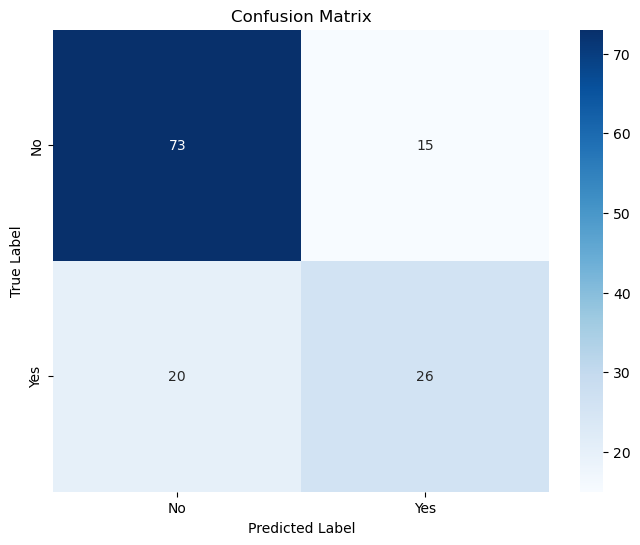

Accuracy: 73.88%


In [293]:
classifier = LogisticRegression(random_state=6)
classifier.fit(TD.x_train_tensor, TD.y_train_tensor)

y_pred = classifier.predict(TD.x_val_tensor) 

print_results(TD.y_val_tensor, y_pred, TD.y_encoding.values())

## Decision Tree 

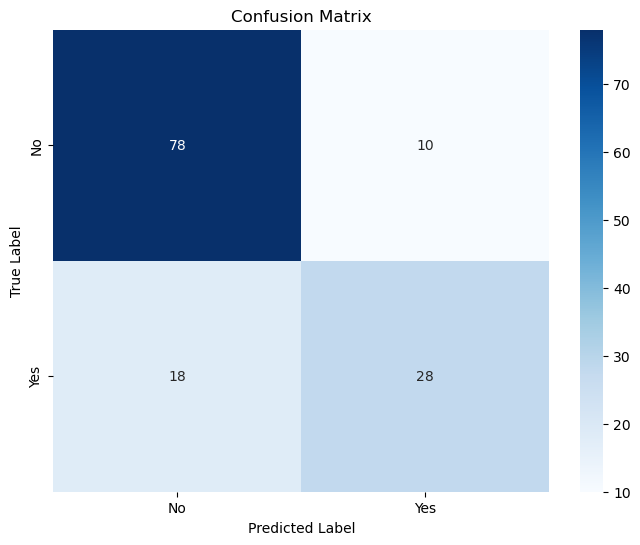

Accuracy: 79.10%


In [294]:
tree_classifier = DecisionTreeClassifier(random_state=0)
tree_classifier.fit(TD.x_train_tensor, TD.y_train_tensor)
y_pred = tree_classifier.predict(TD.x_val_tensor) 

print_results(TD.y_val_tensor, y_pred, TD.y_encoding.values())

## Nueral Network

In [300]:
class Titanic_NN(nn.Module):
    def __init__(self, neurons_one, neurons_two, dropout_rate, learning_rate):
        super(Titanic_NN, self).__init__()
        self.layer_one = nn.Linear(6, neurons_one) # number of input features, 
        self.layer_two = nn.Linear(neurons_one, neurons_two) 
        self.layer_three = nn.Linear(neurons_two, 1) # number of ,outputs 
        self.learning_rate = learning_rate
        self.dropout = nn.Dropout(p=dropout_rate)


    def forward(self, x):
        x = torch.relu(self.layer_one(x)) 
        x = self.dropout(x)
        x = torch.relu(self.layer_two(x))
        x = torch.sigmoid(self.layer_three(x)) 
        
        return x.squeeze() 

    def train_model(self, train_loader:DataLoader, epochs=100, val_loader:DataLoader=None,  early_stop_file_name='Model_state.pth', patience=10):
        """
        Trains Model from given train_loader.
        """
        loss_function = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        # early stopping vars
        best_val_loss = float('inf')
        patience_counter = 0
        epoch_model_saved_at = 0
        
        for epoch in range(epochs):
            self.train() # train mode
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            if val_loader != None:
                self.eval()  # evaluation mode
                val_loss = 0
                with torch.no_grad():
                    for val_inputs, val_labels in val_loader:
                        val_outputs = self(val_inputs)
                        val_loss += loss_function(val_outputs, val_labels).item()
                val_loss /= len(val_loader)
                
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
            
            if val_loader != None:
                # check early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    epoch_model_saved_at=epoch
                    torch.save(self.state_dict(), early_stop_file_name)
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Stopping early due to no improvement in validation loss. Best epoch at {epoch_model_saved_at}")
                        break

    def eval_model(self, test_loader:DataLoader)-> tuple[list,list]: 
        """
        Evaulates the model
        @param - test_loader - data loader with the data to eval.
        @returns [y_actual, y_pred]
        """
        self.eval()  # evaluation mode
        y_pred = []
        y_actual = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self(inputs)
                predicted = (outputs > 0.5).float()
                y_pred.extend(predicted.numpy())   
                y_actual.extend(labels.numpy()) 
                
        return y_actual, y_pred
    
    def make_predictions(self, test_tensor: torch.tensor)-> list:
        """
        Given a tensor of inputs output list of predictions. 
        @param test_tensor - tensor with inputs to eval.
        @retrun - y_pred
        """
        self.eval()  # evaluation mode
        y_pred = []
        
        with torch.no_grad():
            for idx, input_v in enumerate(test_tensor):
                outputs = self(input_v)
                predicted = (outputs > 0.5).float()
                y_pred.append(int(predicted.item()))  
                
        return y_pred       

### NN Model Test 

Epoch 1/100, Loss: 0.6529
Epoch 11/100, Loss: 0.2878
Epoch 21/100, Loss: 0.1950
Epoch 31/100, Loss: 0.4301
Epoch 41/100, Loss: 0.3470
Stopping early due to no improvement in validation loss. Best epoch at 26


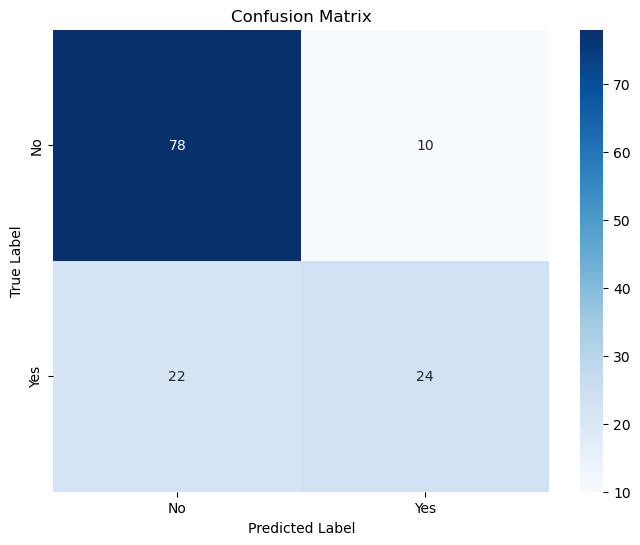

Accuracy: 76.12%


In [301]:
neurons_one=100
neurons_two=200
dropout_rate=.15
learning_rate =.001
t_model = Titanic_NN(neurons_one, neurons_two, dropout_rate, learning_rate) 
early_stop_file_name='Best_titanic_model.pth'

t_model.train_model(TD.train_loader, val_loader= TD.val_loader, early_stop_file_name=early_stop_file_name, patience=20)
t_model.load_state_dict(torch.load(early_stop_file_name))

y_actual, y_pred = t_model.eval_model(TD.val_loader)

print_results(y_actual, y_pred, TD.y_encoding.values())

# how to load model state 
# model = Titanic_NN()  
# model.load_state_dict(torch.load('best_model_state.pth'))

### NN Model hyper parameter tune 

In [311]:
def train_and_evaluate_model(train_loader, val_loader, neurons_one, neurons_two, dropout_rate, learning_rate, early_stop_file_name):
    t_model = Titanic_NN(neurons_one, neurons_two, dropout_rate, learning_rate)
    
    t_model.train_model(train_loader, val_loader= val_loader, early_stop_file_name=early_stop_file_name, patience=20)
    t_model.load_state_dict(torch.load(early_stop_file_name))
    
    y_actual, y_pred = t_model.eval_model(TD.val_loader)
    accuracy = accuracy_score(y_actual, y_pred)
    return accuracy

#### Random Paramater hyper Tune

In [303]:
num_iterations=30
best_performance = None
best_hyperparameters = None
best_filename = None

neurons_one_list=[50, 100]
neurons_two_list=[50, 100]
dropout_rate_list=[.001, .01, .1, .2]
learning_rate_list = [.001, .01 , .1]

for idx in range(num_iterations):
    early_stop_file_name=f'Best_titanic_model_{idx}.pth'
    neurons_one= random.choice(neurons_one_list)
    neurons_two= random.choice(neurons_two_list)
    dropout_rate= random.choice(dropout_rate_list)
    learning_rate= random.choice(learning_rate_list)
    print(neurons_one, neurons_two, dropout_rate, learning_rate)
    performance = train_and_evaluate_model(TD.train_loader, TD.val_loader, neurons_one, neurons_two, dropout_rate, learning_rate, early_stop_file_name)
     

    if best_performance is None or performance > best_performance:
        best_performance = performance
        best_hyperparameters = (neurons_one, neurons_two, dropout_rate, learning_rate)
        best_filename = early_stop_file_name

print(f"Best Performance: {best_performance}")
print(f"Best Hyperparameters: Neurons Layer One: {best_hyperparameters[0]}, Neurons Layer Two: {best_hyperparameters[1]}, Dropout Rate: {best_hyperparameters[2]}, Learning Rate: {best_hyperparameters[3]}")
print(f"Best Filename: {best_filename}")

50 50 0.1 0.1
Epoch 1/100, Loss: 0.8178
Epoch 11/100, Loss: 0.5860
Epoch 21/100, Loss: 0.8793
Epoch 31/100, Loss: 0.7385
Stopping early due to no improvement in validation loss. Best epoch at 12
50 100 0.2 0.1
Epoch 1/100, Loss: 0.6340
Epoch 11/100, Loss: 0.3823
Epoch 21/100, Loss: 0.7697
Epoch 31/100, Loss: 0.5560
Stopping early due to no improvement in validation loss. Best epoch at 10
50 50 0.001 0.1
Epoch 1/100, Loss: 0.6224
Epoch 11/100, Loss: 0.2614
Epoch 21/100, Loss: 0.0346
Epoch 31/100, Loss: 0.2818
Stopping early due to no improvement in validation loss. Best epoch at 10
50 100 0.1 0.1
Epoch 1/100, Loss: 1.5026
Epoch 11/100, Loss: 0.2349
Epoch 21/100, Loss: 0.2925
Epoch 31/100, Loss: 0.6839
Stopping early due to no improvement in validation loss. Best epoch at 10
50 50 0.1 0.01
Epoch 1/100, Loss: 0.6654
Epoch 11/100, Loss: 0.5071
Epoch 21/100, Loss: 0.5597
Epoch 31/100, Loss: 0.8555
Epoch 41/100, Loss: 0.2342
Stopping early due to no improvement in validation loss. Best epoch

#### Combination parameter Hyper tune    

In [314]:
best_performance = None
best_hyperparameters = None
best_filename = None

neurons_one_list=[50, 100]
neurons_two_list=[50, 100]
dropout_rate_list=[.001, .01, .1, .2]
learning_rate_list = [.001, .01 , .1]

all_combinations = list(product(neurons_one_list, neurons_two_list, dropout_rate_list, learning_rate_list))

for idx, combination in enumerate(all_combinations):
    neurons_one, neurons_two, dropout_rate, learning_rate = combination
        
    early_stop_file_name=f'Best_titanic_model_{idx}.pth'
    
    print(neurons_one, neurons_two, dropout_rate, learning_rate)
    performance = train_and_evaluate_model(TD.train_loader, TD.val_loader, neurons_one, neurons_two, dropout_rate, learning_rate, early_stop_file_name)
     

    if best_performance is None or performance > best_performance:
        best_performance = performance
        best_hyperparameters = (neurons_one, neurons_two, dropout_rate, learning_rate)
        best_filename = early_stop_file_name

print(f"Best Performance: {best_performance}")
print(f"Best Hyperparameters: Neurons Layer One: {best_hyperparameters[0]}, Neurons Layer Two: {best_hyperparameters[1]}, Dropout Rate: {best_hyperparameters[2]}, Learning Rate: {best_hyperparameters[3]}")
print(f"Best Filename: {best_filename}")

50 50 0.001 0.001
Epoch 1/100, Loss: 0.2968
Epoch 11/100, Loss: 0.5130
Epoch 21/100, Loss: 0.1180
Epoch 31/100, Loss: 0.1568
Stopping early due to no improvement in validation loss. Best epoch at 14
50 50 0.001 0.01
Epoch 1/100, Loss: 0.5174
Epoch 11/100, Loss: 0.4134
Epoch 21/100, Loss: 0.7652
Epoch 31/100, Loss: 0.3977
Epoch 41/100, Loss: 0.0572
Epoch 51/100, Loss: 0.2137
Epoch 61/100, Loss: 0.2498
Epoch 71/100, Loss: 0.2891
Stopping early due to no improvement in validation loss. Best epoch at 56
50 50 0.001 0.1
Epoch 1/100, Loss: 2.0434
Epoch 11/100, Loss: 0.6172
Epoch 21/100, Loss: 0.1783
Stopping early due to no improvement in validation loss. Best epoch at 6
50 50 0.01 0.001
Epoch 1/100, Loss: 0.5478
Epoch 11/100, Loss: 0.2434
Epoch 21/100, Loss: 0.8854
Epoch 31/100, Loss: 0.4717
Epoch 41/100, Loss: 0.6470
Epoch 51/100, Loss: 0.7366
Epoch 61/100, Loss: 0.2244
Epoch 71/100, Loss: 0.7205
Epoch 81/100, Loss: 0.1616
Epoch 91/100, Loss: 0.2146
Stopping early due to no improvement in 

### Final model Train with all data 

In [315]:
t_model = Titanic_NN(neurons_one=50, neurons_two=100, dropout_rate=.01, learning_rate=.001) 
t_model.train_model(TD.final_train_loader, epochs= 50)
y_pred = t_model.make_predictions(TD.x_test_tensor)

submission = pd.DataFrame({'PassengerId': TD.test_ids, 'Survived': y_pred})
submission.to_csv('Submission.csv', index=False)

Epoch 1/50, Loss: 0.3516
Epoch 11/50, Loss: 0.3000
Epoch 21/50, Loss: 1.9860
Epoch 31/50, Loss: 0.3649
Epoch 41/50, Loss: 0.3120


In [316]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
